# Detection probability

In the paper, the detection of individual sources is defined as $\lambda > 5\sigma$, where $\lambda$ is the test statistic resulting from the IceCube point source search. To connect this statement to the source parameters in the hierarchical model, we use simulations of neutrino detection in IceCube for different source parameters. The simulated data is then run through the point search search algorithm to find the detection probability and discovery potential. 

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt

colormap = plt.cm.viridis

In [2]:
from icecube_tools.detection_probability import (get_simulated_params, 
                                                 get_detection_probability)
from icecube_tools.detection_probability import get_TS_threshold
from icecube_tools.detection_probability import fit_func
from icecube_tools.detector.effective_area import EffectiveArea
from icecube_tools.neutrino_calculator import PhiSolver
from scipy.ndimage.filters import gaussian_filter1d

## Simulation of neutrino detection in IceCube

The simulation makes use of the `icecube_tools` python package. See the following python scripts in the `scripts/` directory of this repository:
* `simulate_bg.py`: Background only
* `simulate_pl.py`: Power law simulation for reweighting 
* `simulate_sources_dec.py`: Simulate source events from a range of declinations 

## Point source search on simulated data

The point source search algorithm is implemented following the approach used in Aartsen+2019, and also makes use of the `icecube_tools` package. See the following python scripts in the `scripts` diriectotry of this repository:
* `TS_dist_bg.py`: Background only
* `TS_dist_dec.py`: Sources over a range of declinations

## Calculation of detection probability
This calculation is *slow* (~20 min), but can be run once and the resulting `output/precomputed_pdet_XXX.h5` files can be used in the subsequent sections. These files are provided such that the reader can just skip ahead to the discovery potential comparison.  

In [ ]:
from tqdm.autonotebook import tqdm as progress_bar

In [ ]:
# Use background to set TS thresholds
bg_file = "output/TS_dist_bg_30_3_withE_Nevents497.h5"
with h5py.File(bg_file, 'r') as f:
    dec_to_sim = f["dec_to_sim"][()]
    TS = []
    for dec in dec_to_sim:
        TS.append(f["TS_%.2f" % dec][()])
        
fivesig_level = 5.7e-7/2
TS_th = np.zeros(len(dec_to_sim))
fit_params = []
for i, dec in enumerate(dec_to_sim):
    TS_th[i], out, _ = get_TS_threshold(abs(TS[i]), fivesig_level, 
                                        above=max(TS[i])/4) # 6, 10
    fit_params.append(out)
    
ps = np.polyfit(np.sin(dec_to_sim), TS_th, 3)
poly = np.poly1d(ps)

In [ ]:
# Use injected source sim to find Pdet given above thresholds
source_file = "output/TS_dist_dec_30_3_6_Nevents497.h5"
dec_to_sim, index_to_sim = get_simulated_params(source_file)

Pdet_dec = []
for i in progress_bar(range(len(dec_to_sim)), desc='Pdet calc'):
    dec = dec_to_sim[i]
    Pdet_index = []
    for j, index in enumerate(index_to_sim):
        Nsrc_list, P = get_detection_probability(source_file, index, dec,
                                                 poly(np.sin(dec)))
        Pdet_index.append(P)
    Pdet_dec.append(Pdet_index)
Pdet_dec = np.array(Pdet_dec)

In [ ]:
# Write results to file
with h5py.File("ouput/precomputed_pdet_30_3_6_Nevents497_v1.h5", 'w') as f:
    f.create_dataset("dec_to_sim", data=dec_to_sim)
    f.create_dataset("index_to_sim", data=index_to_sim)
    f.create_dataset("Nsrc_list", data=Nsrc_list)
    for i, dec in enumerate(dec_to_sim):
        folder = f.create_group("dec_%.2f" % dec)
        for j, index in enumerate(index_to_sim):
            subfolder = folder.create_group("index_%.2f" % index)
            subfolder.create_dataset("Pdet", data=Pdet_dec[i][j])

## Discovery potential comparison

In [6]:
precomp_file = "output/precomputed_pdet_30_3_6_Nevents497.h5" 

# Read in data
with h5py.File(precomp_file, 'r') as f:
    dec_to_sim = f["dec_to_sim"][()]
    index_to_sim = f["index_to_sim"][()]
    Nsrc_list = f["Nsrc_list"][()]
    Pdet_dec = np.zeros((len(dec_to_sim), len(index_to_sim), len(Nsrc_list)))
    for i, dec in enumerate(dec_to_sim):
        folder = f["dec_%.2f" % dec]
        for j, index in enumerate(index_to_sim):
            subfolder = folder["index_%.2f" % index]
            Pdet_dec[i][j] = subfolder["Pdet"][()]

In [7]:
# Find the 50% level that defines the dsicovery potential for each index
mean_events = []
for j, index in enumerate(index_to_sim):
    me = [np.interp(0.5, P, Nsrc_list) for P in np.transpose(Pdet_dec, (1,0,2))[j]]
    mean_events.append(me)

In [8]:
# Convert expected Nnu from source -> source flux
Aeff_filename = "input/IC86-2012-TabulatedAeff.txt"
effective_area = EffectiveArea(Aeff_filename)

phi_solver = PhiSolver(effective_area=effective_area, Emin=1e3, 
                       time=7.0, max_cosz=0.1, Emax=5e10, Enorm=1e5)

flux = []
for j, index in enumerate(index_to_sim):
    f = [phi_solver(Nnu, np.rad2deg(dec), index) 
         for Nnu, dec in zip(mean_events[j], dec_to_sim)]
    flux.append(f)

### Fig. 2

In [9]:
# Actual values from Fig. 18 in Aartsen+2019 for comparison
ic_2 = np.loadtxt("input/Aartsen+2019_fig18_2.csv", delimiter=',')
ic_2p19 = np.loadtxt("input/Aartsen+2019_fig18_2p19.csv", delimiter=',')

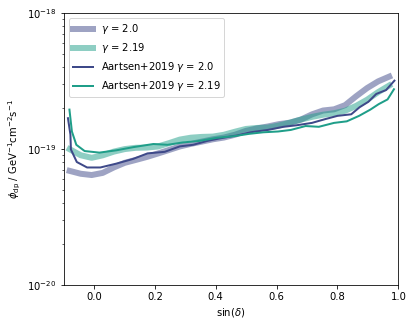

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 5))
colors = colormap(np.linspace(0, 1, 10))

ax.plot(np.sin(dec_to_sim), gaussian_filter1d(flux[1], sigma=1.0), color=colors[2],
            alpha=0.5, label="$\gamma$ = 2.0", linestyle='-', lw=6)
ax.plot(np.sin(dec_to_sim), gaussian_filter1d(flux[2], sigma=1.0), color=colors[5],
            alpha=0.5, label="$\gamma$ = 2.19", linestyle='-', lw=6)
ax.plot(ic_2.T[0], ic_2.T[1], color=colors[2], linestyle='-', 
        label="Aartsen+2019 $\gamma$ = 2.0", lw=2)
ax.plot(ic_2p19.T[0], ic_2p19.T[1], color=colors[5], linestyle='-', 
        label="Aartsen+2019 $\gamma$ = 2.19", lw=2)
ax.set_yscale("log")
ax.set_ylim(1e-20, 1e-18)
ax.legend()
ax.set_xlabel("sin($\delta$)")
ax.set_ylabel("$\phi_\mathrm{dp}$ / $\mathrm{GeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}$");
ax.set_xlim(-0.1, 1);

## Visualising the detection probability

In [14]:
from icecube_tools.neutrino_calculator import zSolver
import matplotlib as mpl

In [15]:
phi = np.zeros((len(dec_to_sim), len(index_to_sim), len(Nsrc_list)))
for i, dec in enumerate(dec_to_sim):
    for j, index in enumerate(index_to_sim):
        phi_tmp = [phi_solver(Nnu, np.rad2deg(dec), index) 
                   for Nnu in Nsrc_list]
        phi[i][j] = phi_tmp

In [16]:
# For each dec and index, get bands of 0.4/0.6, 0.2/0.8 and 0/1
Pdet_levels = np.linspace(0.000, 0.99, 10)
potential = np.zeros((len(Pdet_levels), len(dec_to_sim), len(index_to_sim)))

for p, pdet in enumerate(Pdet_levels):
    for i, dec in enumerate(dec_to_sim):
        for j, index in enumerate(index_to_sim):
            phi_tmp = phi[i][j]
            Pdet_dec_tmp = Pdet_dec[i][j]
            phi_lim = phi_tmp[np.argmax(Pdet_dec_tmp)]
            l = np.interp(pdet, Pdet_dec_tmp[phi_tmp<phi_lim], 
                          phi_tmp[phi_tmp<phi_lim])
            potential[p][i][j] = l

In [17]:
potentials = np.zeros((len(Pdet_levels), len(index_to_sim), len(dec_to_sim)))
for p, pdet in enumerate(Pdet_levels):
    for j, index in enumerate(index_to_sim):
        potentials[p][j] = gaussian_filter1d(potential[p].T[j], sigma=1.5)

In [18]:
# Fix constant rate and gamma to find proper L
rate = 1e44 # s^-1
Emin = 100 # TeV

# Initialise redshift solver
z_solver = zSolver(Emin)

In [19]:
# Find redshift corresponding to phi_norm, rate and gamma
redshift = np.zeros((len(Pdet_levels), len(index_to_sim), len(dec_to_sim)))
for p, pdet in enumerate(Pdet_levels):
    for j, index in enumerate(index_to_sim):
        if index == 2.0:
            index = 2.001 # To handle normalisation
        L = z_solver.get_L(rate, index)
        for i, dec in enumerate(dec_to_sim):
            z_tmp = z_solver(potentials[p][j][i]*1e3, L, index, guess=0.1)
            redshift[p][j][i] = z_tmp

redshift[redshift>10] = 10

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


### Fig. 3

In [20]:
origin = np.tile(0, len(dec_to_sim))

dec_to_sim_f = dec_to_sim
dec_to_sim_f[-1] = np.pi/2

In [21]:
colors = colormap(np.linspace(0, 1, 10))
cmap_p = mpl.colors.LinearSegmentedColormap.from_list("custom", ['w', colors[2]],
                                                      N=len(Pdet_levels)) 

cmap_g = mpl.colors.LinearSegmentedColormap.from_list("custom", ['w', colors[5]], 
                                                      N=len(Pdet_levels)) 
sm_p = plt.cm.ScalarMappable(cmap=cmap_p)
sm_g = plt.cm.ScalarMappable(cmap=cmap_g)

Text(0.017453292519943295, 1.95, 'Equator')

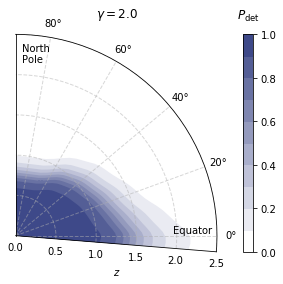

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.set_xlim(dec_to_sim[0], np.pi/2)
ax.set_ylim(0, 2.5)
ax.set_xlabel("$z$", labelpad=15)
for p, pdet in enumerate(Pdet_levels):
    ax.fill_between(dec_to_sim_f, origin, redshift[p][1], 
                    color=cmap_p(p), lw=0)
cbar = fig.colorbar(sm_p, ax=ax)
ax.set_title("$\gamma=2.0$")
cbar.ax.set_title("$P_\mathrm{det}$", pad=15)
ax.grid(True, lw=1, alpha=0.5, linestyle='--')
ax.text(np.deg2rad(88), 2.15, "North\nPole")
ax.text(np.deg2rad(1), 1.95, "Equator")

Text(0.017453292519943295, 1.95, 'Equator')

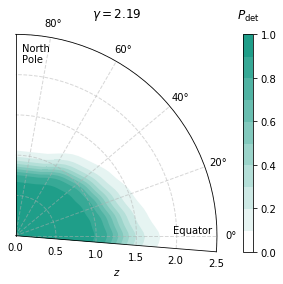

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.set_xlim(dec_to_sim[0], dec_to_sim[-1])
ax.set_ylim(0, 2.5)
ax.set_xlabel("$z$", labelpad=15)
for p, pdet in enumerate(Pdet_levels):
    ax.fill_between(dec_to_sim_f, origin, redshift[p][2], 
                    color=cmap_g(p), lw=0)
cbar = fig.colorbar(sm_g, ax=ax)
ax.set_title("$\gamma=2.19$")
cbar.ax.set_title("$P_\mathrm{det}$", pad=15)
ax.grid(True, lw=1, alpha=0.5, linestyle='--')
ax.text(np.deg2rad(88), 2.15, "North\nPole")
ax.text(np.deg2rad(1), 1.95, "Equator")

## Convert to Stan input
In order to include the detection probability into the hierarchical model, we must parametrise it, then interpolate over these parameters in the `Stan` model.

In [24]:
from scipy.optimize import curve_fit

In [25]:
def fit_func(phi, centre, width):
    return  1 / ( 1 + np.power(width, -(np.log(phi)-np.log(centre)) ) )

/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/fran/.virtualenvs/bayes/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


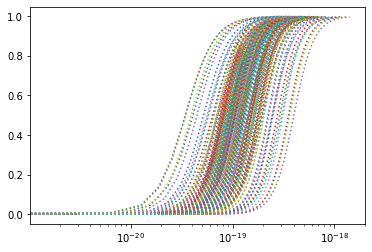

In [26]:
fit_params = np.zeros((len(dec_to_sim), len(index_to_sim), 2))

for i, dec in enumerate(dec_to_sim):
    for j, index in enumerate(index_to_sim):
        phi_tmp = phi[i][j]
        Pdet_dec_tmp = Pdet_dec[i][j]
        
        out, _ = curve_fit(fit_func, phi_tmp, Pdet_dec_tmp, p0=[1e-19, 50])
        fit_params[i][j] = out                      

In [27]:
# Summary
fit_params = np.transpose(fit_params, (2, 0, 1))
Pdet_cen = fit_params[0]
Pdet_width = fit_params[1]

# Binning
x = np.diff(np.sin(dec_to_sim))[0]
sindec_bins = np.sin(dec_to_sim) - x/2
sindec_bins = np.append(sindec_bins, np.sin(dec_to_sim[-1])+x/2)

with h5py.File("output/pdet_params_Nevents497.h5", 'w') as f:
    f.create_dataset("sindec_bins", data=sindec_bins)
    f.create_dataset("index_grid", data=index_to_sim)
    f.create_dataset("Pdet_cen", data=Pdet_cen)
    f.create_dataset("Pdet_width", data=Pdet_width)